In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interpolate
import tabulate
import torch

from IPython.display import HTML, display
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data
from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import pinv
from scipy.optimize import brute, lsq_linear
from torch.optim import Adam

import pandas as pd

## Load data
(Source: https://www.reddit.com/r/joinsquad/comments/bp7msu/rocket_techie_range_card/)  
Thanks to u/AbsentWizard and u/Kumbulah!

In [2]:
measurements = pd.read_csv('./data/elevation_range_measurements.csv', index_col=0).values
elevations = np.deg2rad(measurements[:, 0])
ranges = measurements[:, 1]


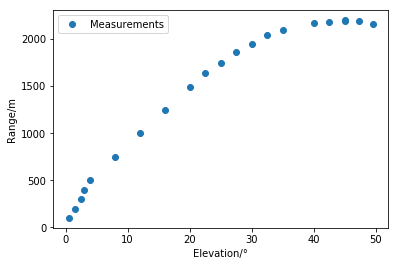

In [3]:
plt.plot(np.rad2deg(elevations), ranges, linestyle='None', marker='o')
plt.xlabel('Elevation/°')
plt.ylabel('Range/m')
plt.legend(['Measurements'])

## Linear regression

Assuming we are firing in a vacuum from height zero onto an unelevated position, we can just use

$$d(\theta, v_0) = 2 \frac{{v_0}^2}{g} \sin(\theta) \cos(\theta) = \frac{{v_0}^2}{g} \sin(2 \theta)$$

and perform linear regression with weight ${v_0}^2$.

In [4]:
def basis_fn(x, g=9.81):
    return 1.0 / g * np.sin(2 * x)

In [5]:
def linear_regression_unelevated(elevations, ranges):
    feature_vector = basis_fn(elevations)
    pseudo_inverse = pinv(np.expand_dims(feature_vector, axis=1))

    weight = np.matmul(pseudo_inverse, ranges)
    return np.sqrt(weight)

In [6]:
v_0 = linear_regression_unelevated(elevations, ranges)
v_0_linear_regression = v_0
print(f'v_0 = {v_0} m/s')

v_0 = [148.34056427] m/s


In [7]:
grid = np.linspace(0, np.pi / 2, 10001)

Text(0, 0.5, 'Range/m')

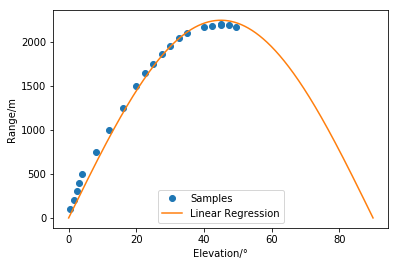

In [8]:
plt.plot(np.rad2deg(elevations), ranges, linestyle='None', marker='o')
plt.plot(np.rad2deg(grid), (v_0 ** 2) * basis_fn(grid))


plt.legend(('Samples',
            'Linear Regression'
            ))


plt.xlabel('Elevation/°')
plt.ylabel('Range/m')

#### Observation:
We get an ok fit, but some points are clearly inaccurate (e.g. the range for elevation 0° should clearly be higher than 0, as the rockets are fired from about 2m above the ground)

## Accounting for vehicle height

To incorporate the height $y_0$ of our rocket techie, we can use the formula

$$ d(\theta, v_0, y_0) = \frac{{v_0}^2}{g} ( v_0 \sin(\theta) + \sqrt{ (v_0 \sin(\theta))^2 + 2 g y_0 } ) $$



In [9]:
def get_range(elevation, v_0, y_0, g=9.81):
    return (v_0 / g * np.cos(elevation) *
            (v_0 * np.sin(elevation) +
            np.sqrt((v_0 * np.sin(elevation)) ** 2 + 2 * g * y_0)))

This is clearly a nonlinear function $\mathcal{R^3} \mapsto \mathcal{R}$, let's visualize it for some values of $\theta$.

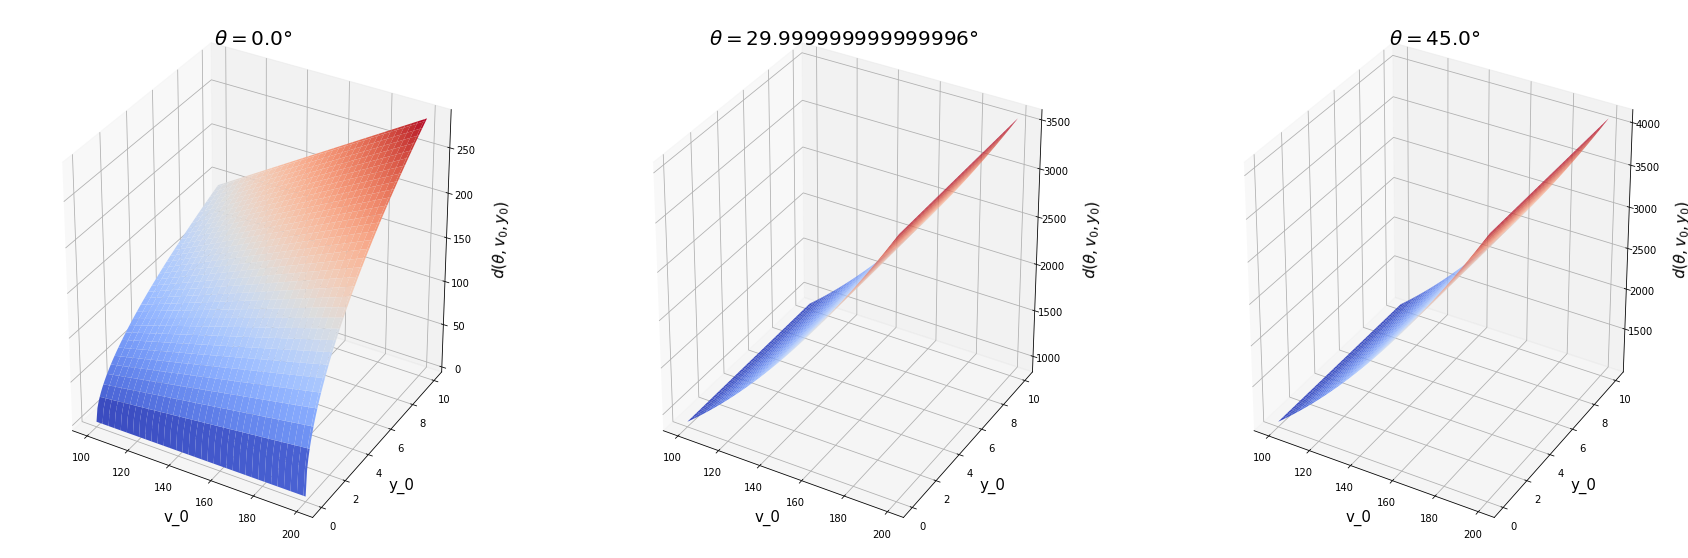

In [10]:
elevations = np.deg2rad(np.array([0, 30, 45]))
initial_velocities = np.linspace(100, 200, 101)
vehicle_heights = np.linspace(0, 10, 101)

initial_velocities, vehicle_heights = np.meshgrid(initial_velocities, vehicle_heights)

figure = plt.figure(figsize=(30, 10))

for subplot_idx, elevation in enumerate(elevations):
    distances = get_range(elevation, initial_velocities, vehicle_heights)
    ax = plt.subplot(1, 3, subplot_idx + 1, projection='3d')
    
    ax.plot_surface(initial_velocities, vehicle_heights, distances, cmap=cm.coolwarm)
    plt.title(r'$\theta = {}°$'.format(np.rad2deg(elevation)), fontsize=20)

    ax.set_xlabel('\n' + r'v_0', fontsize=15, linespacing=1)
    ax.set_ylabel('\n' + r'y_0', fontsize=15, linespacing=2)
    ax.set_zlabel('\n' + r'$d(\theta, v_0, y_0)$', fontsize=15, linespacing=3)


### Nonlinear regression via gradient descent
Let's find the optimal $v_0$ and $y_0$ via gradient descent, using some reasonable initial values.

In [11]:
def get_range_tensors(elevation, v_0, y_0, g=9.81):
    return (v_0 / g * torch.cos(elevation) *
            (v_0 * torch.sin(elevation) +
            torch.sqrt((v_0 * np.sin(elevation)) ** 2 + 2 * g * y_0)))

v_0 = 147.60348510742188
y_0 = 8.825782775878906
MSE = 2595.44482421875


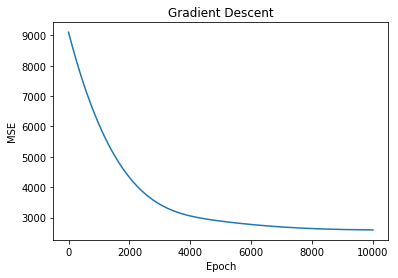

In [12]:
elevations = torch.tensor(np.deg2rad(measurements[:, 0])).float()
ranges = torch.tensor(measurements[:, 1]).float()

v_0 = torch.tensor(145.0, requires_grad=True).float()
y_0 = torch.tensor(2.0, requires_grad=True).float()

optimizer = Adam([v_0, y_0])

error_per_epoch = []

for epoch in range(10000):

    optimizer.zero_grad()

    estimated_range = get_range_tensors(elevations, v_0, y_0)
    mse = torch.mean((estimated_range - ranges) ** 2)

    loss = mse
    loss.backward()
    optimizer.step()
    
    error_per_epoch.append(mse.detach().numpy())
    
plt.plot(error_per_epoch)
plt.title('Gradient Descent')
plt.xlabel('Epoch')
plt.ylabel('MSE')

print(f'v_0 = {v_0}')
print(f'y_0 = {y_0}')
print(f'MSE = {mse.detach().numpy()}')

Text(0, 0.5, 'Range/m')

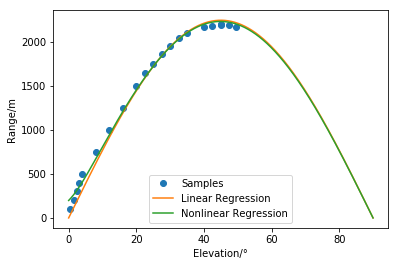

In [13]:
grid = np.linspace(0, np.pi / 2, 10001)

elevations = np.deg2rad(measurements[:, 0])
ranges = measurements[:, 1]

plt.plot(np.rad2deg(elevations), ranges, linestyle='None', marker='o')
plt.plot(np.rad2deg(grid), (v_0_linear_regression ** 2) * basis_fn(grid))
plt.plot(np.rad2deg(grid), get_range(grid, v_0.detach().numpy(), y_0.detach().numpy()))


plt.legend(('Samples',
            'Linear Regression',
            'Nonlinear Regression'
            ))


plt.xlabel('Elevation/°')
plt.ylabel('Range/m')

### Nonlinear regression via grid search
For this simple problem, we might es well optimize via grid search

In [14]:
def brute_loss(*args):
    v_0 = args[0][0]
    y_0 = args[0][1]
    elevations = args[1]
    ranges = args[2]
    estimated_ranges = get_range(elevations, v_0, y_0, g=9.81)
    loss = np.mean((estimated_ranges - ranges) ** 2)
    return loss

In [15]:
elevations = np.deg2rad(measurements[:, 0])
ranges = measurements[:, 1]

v_0, y_0 = brute(brute_loss, (slice(100, 200, 0.1), slice(0, 10, 0.1)), (elevations, ranges))

print(f'v_0 = {v_0}')
print(f'y_0 = {y_0}')
print(f'MSE = {brute_loss([v_0, y_0], elevations, ranges)}')

v_0 = 147.56543763432268
y_0 = 9.27785755499206
MSE = 2590.8256024314805


## Conclusion:
We were able to fit the given datapoints quite well.  
The current modelling suggests an unreasonably high starting height.  
It's possible that OWI modelled the rockets to only start their ballistic trajectory x meters after leaving the launcher.  
Another possible reason is that we require a larger amount of training data to account for the stochasticity of the horizontal and vertical firing angle.

## Range Tables Based on Linear Regression

### Table Elevation -> Range

In [16]:
table_elevations = np.deg2rad(np.arange(0, 90.5, 0.5))
table_ranges = get_range(table_elevations, 147.56543763432268, 9.27785755499206)


#table_elevations_inverse = np.arcsin((table_ranges_inverse - offset_all) * 2 / weight_all) / 2 / np.pi * 180

table = [(elevation, missile_range) for elevation, missile_range in zip(np.rad2deg(table_elevations), table_ranges)]
display(HTML(tabulate.tabulate(table,
                               tablefmt='html',
                               headers=('Elevation / °', 'Range / m'))))

Elevation / °,Range / m
0,202.95
0.5,223.234
1,245.317
1.5,269.118
2,294.52
2.5,321.38
3,349.539
3.5,378.836
4,409.115
4.5,440.229


### Table Range -> Elevation
Calculated via $$\theta = \arctan{\left(\frac{v^2\pm\sqrt{v^4-g(gx^2+2yv^2)}}{gx}\right)}$$

In [17]:
def get_elevation(target_range, v_0, delta_y, g=9.81):
    x = (v_0) ** 4 - g * (g * (target_range ** 2) + 2 * delta_y * (v_0 ** 2))

    if x < 0:
        return None, None
    
    x = np.sqrt(x)
    
    x_1 = ((v_0 ** 2) + x) / (g * target_range)
    x_2 = ((v_0 ** 2) - x) / (g * target_range)

    elevation_1 =  np.arctan(x_1)
    elevation_2 = np.arctan(x_2)
    
    return [np.arctan(x) if np.arctan(x) >= 0 else None for x in [x_1, x_2]]

def elevation_list_to_deg(x):
    for i in range(len(x)):
        for j in range(2):
            if x[i][j] is not None:
                x[i][j] = np.rad2deg(x[i][j])

In [28]:
table_ranges_inverse = np.arange(25, 2250, 25)
table_elevations_inverse = [get_elevation(range, 147.56543763432268, -9.27785755499206)
                            for range in table_ranges_inverse]

elevation_list_to_deg(table_elevations_inverse)


table = [(missile_range, elevation[0], elevation[1])
         for missile_range, elevation in zip(table_ranges_inverse, table_elevations_inverse)]
display(HTML(tabulate.tabulate(table,
                               tablefmt='html',
                               headers=('Range / m', 'Elevation 1 / °', 'Elevation 2 / °'))))

Range / m,Elevation 1 / °,Elevation 2 / °
25,89.678,
50,89.356,
75,89.0339,
100,88.7117,
125,88.3893,
150,88.0667,
175,87.7438,
200,87.4207,
225,87.0972,0.541511
250,86.7734,1.10123
